In [1]:
Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)
import os
import numpy as np
import pylab as plt
from time import time
from numba import jit
from os.path import join

output_path = "output"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [2]:
@jit(nopython=True)
def generic_hopf_model(eta, omega, init_conditions, sigma, G, SC, dt, ts):

    epsilon = 0.5
    itaus = 1.25
    itauf = 2.5
    itauo = 1.02040816327
    ialpha = 5.
    Eo = 0.4
    V0 = 4.
    k1 = 2.77264
    k2 = 0.572
    k3 = -0.43

    nt = ts.shape[0]
    nn = SC.shape[0]

    # state variables
    x = np.zeros(nn)
    b = np.zeros((nn, nt))
    y = np.zeros(nn)
    z = np.array([0.]*nn + [1.]*3*nn)
    # act = np.zeros((nn, nt))

    # initial conditions (similar value for all regions)
    x_init, y_init = init_conditions[0], init_conditions[1]
    x[:] = x_init
    y[:] = y_init

    for i in range(nn):
        b[i, 0] = V0*(k1 - k1*z[3*nn+i] + k2-k2 *
                      (z[3*nn+i]/z[2*nn+i]) + k3-k3*z[2*nn+i])

    for t in range(nt-1):
        for i in range(nn):
            gx, gy = 0.0, 0.0
            for j in range(nn):
                gx = gx + SC[j, i]*(x[j] - x[i])
                gy = gy + SC[j, i]*(y[j] - y[i])
            dx = (x[i]*(eta[i]-(x[i]*x[i])-(y[i]*y[i]))) -\
                (omega[i]*y[i]) + (G*gx)
            dy = (y[i]*(eta[i]-(x[i]*x[i])-(y[i]*y[i]))) +\
                 (omega[i]*x[i]) + (G*gy)
            dz0 = epsilon*x[i]-itaus*z[i]-itauf*(z[nn+i]-1)
            dz1 = z[i]
            dz2 = itauo*(z[nn+i]-z[2*nn+i]**ialpha)
            dz3 = itauo * (z[nn+i]*(1-(1-Eo)**(1/z[nn+i]))/Eo -
                           (z[2*nn+i]**ialpha)*z[3*nn+i]/z[2*nn+i])

            x[i] = x[i] + dt*dx + \
                np.sqrt(dt) * sigma * np.random.randn()
            y[i] = y[i] + dt*dy + \
                np.sqrt(dt) * sigma * np.random.randn()

            z[i] = z[i] + dt * dz0
            z[nn+i] = z[nn+i] + dt*dz1
            z[2*nn+i] = z[2*nn+i] + dt * dz2
            z[3*nn+i] = z[3*nn+i] + dt * dz3
            b[i, t+1] = V0*(k1 - k1*z[3*nn+i] + k2-k2 *
                            (z[3*nn+i]/z[2*nn+i]) + k3-k3*z[2*nn+i])
    return b

In [3]:
weights = np.loadtxt(join("data", "weights.txt"))
SC = weights/np.max(weights)
nn = len(SC)
freq_true = np.random.uniform(0.02, 0.04, nn)
omega_true = 2*np.pi*freq_true

x_init = 0
y_init = 0
init_conditions = np.array([x_init, y_init])

sigma = 0.1
G_true = 0.25*100
dt = 0.001
T = 120
ts = np.arange(0, T + dt, dt)

eta_mu_true = -1.
eta_std_true = 1.
eta_heter_rnd = np.random.randn(nn)
eta_true = eta_mu_true+eta_std_true * eta_heter_rnd

In [4]:
start = time()
BOLD = generic_hopf_model(eta_true, omega_true, init_conditions,
                sigma, G_true, SC, dt, ts)
print("Done in {:.3f} seconds".format(time()-start))

Done in 6.411 seconds


(84, 120001)


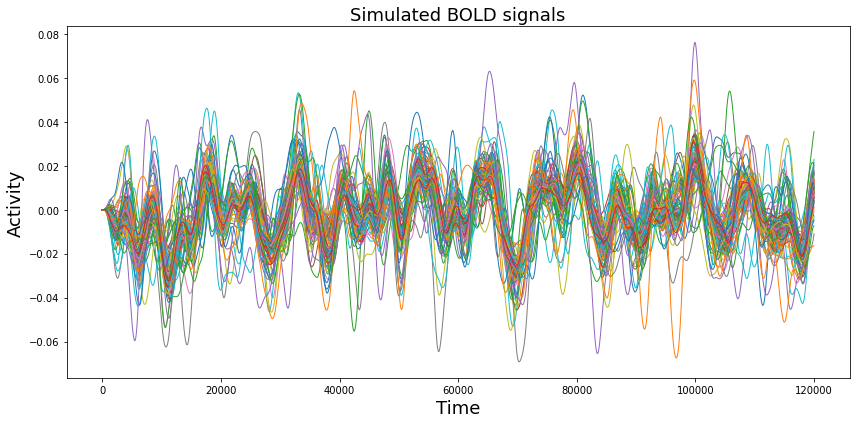

In [5]:
print(BOLD.shape)
np.savez(join(output_path, "bold"), bold=BOLD)

# load data and plot ----------------------------------------------
data = np.load(join(output_path, "bold.npz"))
BOLD = data['bold']

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(BOLD.T, lw=1)
ax.set_title("Simulated BOLD signals", fontsize=18)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Activity', fontsize=18)
plt.tight_layout()
plt.savefig(join("output", "SimulatedBOLD_sanity.png"), dpi=150)